<a href="https://colab.research.google.com/github/EternalSorrrow/bak/blob/master/ra2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!ls 'drive/My Drive/Work/ra2'

Subset_Training  Subset_training.csv


In [3]:
import pandas as pd 

data = pd.read_csv('drive/My Drive/Work/ra2/Subset_training.csv')
data.head()

,Patient_ID,Overall_Tol,Overall_erosion,Overall_narrowing,LH_mcp_E__ip,LH_pip_E__2,LH_pip_E__3,LH_pip_E__4,LH_pip_E__5,LH_mcp_E__1,LH_mcp_E__2,LH_mcp_E__3,LH_mcp_E__4,LH_mcp_E__5,LH_wrist_E__mc1,LH_wrist_E__mul,LH_wrist_E__nav,LH_wrist_E__lunate,LH_wrist_E__radius,LH_wrist_E__ulna,RH_mcp_E__ip,RH_pip_E__2,RH_pip_E__3,RH_pip_E__4,RH_pip_E__5,RH_mcp_E__1,RH_mcp_E__2,RH_mcp_E__3,RH_mcp_E__4,RH_mcp_E__5,RH_wrist_E__mc1,RH_wrist_E__mul,RH_wrist_E__nav,RH_wrist_E__lunate,RH_wrist_E__radius,RH_wrist_E__ulna,LF_mtp_E__ip,LF_mtp_E__1,LF_mtp_E__2,LF_mtp_E__3,...,LH_pip_J__4,LH_pip_J__5,LH_mcp_J__1,LH_mcp_J__2,LH_mcp_J__3,LH_mcp_J__4,LH_mcp_J__5,LH_wrist_J__cmc3,LH_wrist_J__cmc4,LH_wrist_J__cmc5,LH_wrist_J__mna,LH_wrist_J__capnlun,LH_wrist_J__radcar,RH_pip_J__2,RH_pip_J__3,RH_pip_J__4,RH_pip_J__5,RH_mcp_J__1,RH_mcp_J__2,RH_mcp_J__3,RH_mcp_J__4,RH_mcp_J__5,RH_wrist_J__cmc3,RH_wrist_J__cmc4,RH_wrist_J__cmc5,RH_wrist_J__mna,RH_wrist_J__capnlun,RH_wrist_J__radcar,RF_mtp_J__ip,LF_mtp_J__1,LF_mtp_J__2,LF_mtp_J__3,LF_mtp_J__4,LF_mtp_J__5,LF_mtp_J__ip,RF_mtp_J__1,RF_mtp_J__2,RF_mtp_J__3,RF_mtp_J__4,RF_mtp_J__5
0,UAB039,17,13,4,0,0,1,0,0,0,0,0,1,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,3,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,UAB046,43,22,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,2,4,4,4,4
2,UAB058,27,8,19,0,1,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,2,2,2,0,0,0,0,1,0,0,0,0,0,2,2,3,2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,UAB059,128,28,100,0,0,0,1,0,0,0,0,1,0,0,0,5,5,0,2,0,1,0,1,0,1,1,0,1,0,0,0,3,3,0,0,0,0,1,1,...,2,2,2,2,2,2,2,3,3,3,3,3,3,2,2,2,2,2,4,2,2,2,4,3,4,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2
4,UAB082,8,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,2,0,0,0


['UAB039-LF.jpg', 'UAB039-LH.jpg', 'UAB039-RF.jpg', 'UAB039-RH.jpg', 'UAB046-LF.jpg', 'UAB046-LH.jpg', 'UAB046-RF.jpg', 'UAB046-RH.jpg', 'UAB058-LF.jpg', 'UAB058-LH.jpg', 'UAB058-RF.jpg', 'UAB058-RH.jpg', 'UAB059-LF.jpg', 'UAB059-LH.jpg', 'UAB059-RF.jpg', 'UAB059-RH.jpg', 'UAB082-LF.jpg', 'UAB082-LH.jpg', 'UAB082-RF.jpg', 'UAB082-RH.jpg', 'UAB085-LF.jpg', 'UAB085-LH.jpg', 'UAB085-RF.jpg', 'UAB085-RH.jpg', 'UAB088-LF.jpg', 'UAB088-LH.jpg', 'UAB088-RF.jpg', 'UAB088-RH.jpg', 'UAB104-LF.jpg', 'UAB104-LH.jpg', 'UAB104-RF.jpg', 'UAB104-RH.jpg', 'UAB109-LF.jpg', 'UAB109-LH.jpg', 'UAB109-RF.jpg', 'UAB109-RH.jpg', 'UAB111-LF.jpg', 'UAB111-LH.jpg', 'UAB111-RF.jpg', 'UAB111-RH.jpg', 'UAB133-LF.jpg', 'UAB133-LH.jpg', 'UAB133-RF.jpg', 'UAB133-RH.jpg', 'UAB150-LF.jpg', 'UAB150-LH.jpg', 'UAB150-RF.jpg', 'UAB150-RH.jpg', 'UAB191-LF.jpg', 'UAB191-LH.jpg', 'UAB191-RF.jpg', 'UAB191-RH.jpg', 'UAB195-LF.jpg', 'UAB195-LH.jpg', 'UAB195-RF.jpg', 'UAB195-RH.jpg', 'UAB196-LF.jpg', 'UAB196-LH.jpg', 'UAB196-RF.jp

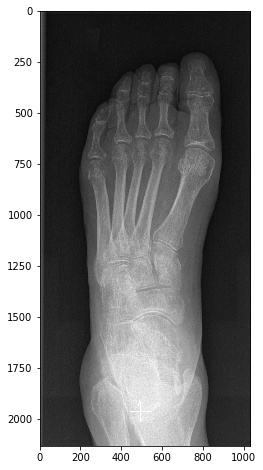

In [4]:
import os
import cv2

path = 'drive/My Drive/Work/ra2/'
imgs = []

files = sorted(os.listdir(path + 'Subset_Training'))
print(files)

for file in files:
  imgs.append((file, cv2.imread(path + 'Subset_Training/' + file)))

import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
plt.imshow(imgs[0][1], cmap = plt.cm.gray)

0.0 0.0


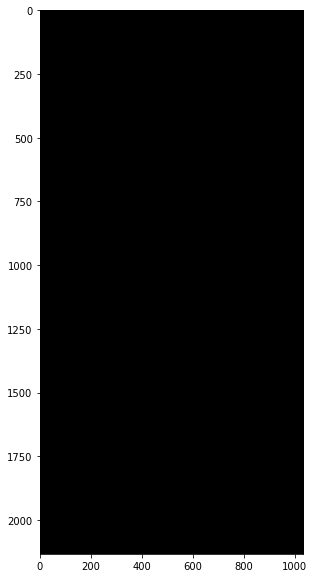

In [5]:
import numpy as np

img = imgs[0][1]

#Sum of the cross-differences between all 3 pairs of channels to determine, can we use a grayscale image without substantional information loss
diff_map = np.abs(img[:,:,0]-img[:, :, 1])+np.abs(img[:,:,0]-img[:, :, 2]) + np.abs(img[:,:,1]-img[:,:,2])

plt.figure(figsize=(10,10))
plt.imshow(diff_map, cmap = plt.cm.gray)

print(np.mean(diff_map), np.var(diff_map))#All 3 channels are the same, we can reduce the input tensor size 3x by using the grayscale image

In [6]:
lfs = [img for img in imgs if 'LF' in img[0]]
rfs = [img for img in imgs if 'RF' in img[0]]
lhs = [img for img in imgs if 'LH' in img[0]]
rhs = [img for img in imgs if 'RH' in img[0]]

print(len(lfs), len(rfs), len(lhs), len(rhs))

50 50 50 50


In [7]:
[print(lf[1].shape, rf[1].shape, lh[1].shape, rh[1].shape) for lf, rf, lh, rh in zip(lfs, rfs, lhs, rhs)]
print()

(2133, 1034, 3) (1869, 1066, 3) (1872, 1872, 3) (2044, 2044, 3)
(1984, 1984, 3) (2252, 2252, 3) (1852, 1852, 3) (1920, 1472, 3)
(2010, 1670, 3) (2010, 1670, 3) (2510, 2000, 3) (2510, 2000, 3)
(2010, 1672, 3) (2010, 1672, 3) (2510, 2000, 3) (2510, 2000, 3)
(2010, 835, 3) (2010, 938, 3) (1670, 1066, 3) (1670, 958, 3)
(1813, 777, 3) (1812, 778, 3) (1269, 897, 3) (1204, 897, 3)
(1756, 910, 3) (1756, 910, 3) (1709, 885, 3) (1710, 884, 3)
(1524, 800, 3) (1524, 800, 3) (1416, 1132, 3) (1416, 1132, 3)
(2010, 1670, 3) (2010, 1670, 3) (2010, 1670, 3) (2010, 1670, 3)
(2008, 1668, 3) (2008, 1668, 3) (2008, 1668, 3) (2008, 1668, 3)
(2468, 1012, 3) (2795, 1217, 3) (1900, 1251, 3) (2256, 1515, 3)
(2010, 1670, 3) (2010, 1670, 3) (2508, 1999, 3) (2508, 1999, 3)
(2362, 2362, 3) (2566, 2566, 3) (2008, 2008, 3) (2221, 1504, 3)
(2010, 1668, 3) (2010, 1668, 3) (2010, 1668, 3) (2010, 1668, 3)
(2010, 1670, 3) (2010, 1670, 3) (2010, 1670, 3) (2010, 1670, 3)
(2010, 1670, 3) (2010, 1670, 3) (2010, 1670, 3) (2010

In [8]:
[print(item[0], item[1].shape) for item in lfs + rfs if item[1].shape[1] > item[1].shape[0]]
print()

UAB692-LF.jpg (743, 1268, 3)
UAB692-RF.jpg (743, 1268, 3)



In [0]:
def make_foot_image_square(image): #Pad an image or cut black pixels if width > height
  delta = image.shape[0] - image.shape[1]  
  lp = abs(delta)//2
  rp = abs(delta) - lp
  
  if delta < 0:
    return image[:, lp:image.shape[1]-rp, :]
  elif delta > 0:
    return cv2.copyMakeBorder(image, 0, 0, lp, rp, cv2.BORDER_CONSTANT, 0)
  return image

In [10]:
[print(item[0], item[1].shape) for item in lhs + rhs if item[1].shape[1] > item[1].shape[0]]
print()

UAB545-LH.jpg (1668, 2008, 3)
UAB692-LH.jpg (743, 1268, 3)
UAB545-RH.jpg (1668, 2008, 3)
UAB692-RH.jpg (743, 1268, 3)



In [0]:
def make_hand_image_square(image): #Pad an image if width > height or height > width
  delta = image.shape[0] - image.shape[1]  
  lp = abs(delta)//2
  rp = abs(delta) - lp
  
  if delta < 0:
    return cv2.copyMakeBorder(image, lp, rp, 0, 0, cv2.BORDER_CONSTANT, 0)
  elif delta > 0:
    return cv2.copyMakeBorder(image, 0, 0, lp, rp, cv2.BORDER_CONSTANT, 0)
  return image

In [0]:
lfs = list(map(lambda x: (x[0], make_foot_image_square(x[1])), lfs))
rfs = list(map(lambda x: (x[0], make_foot_image_square(x[1])), rfs))
lhs = list(map(lambda x: (x[0], make_hand_image_square(x[1])), lhs))
rhs = list(map(lambda x: (x[0], make_hand_image_square(x[1])), rhs))

f = lambda x: x[0]

lfs = sorted(lfs, key=f)
rfs = sorted(rfs, key=f)
lhs = sorted(lhs, key=f)
rhs = sorted(rhs, key=f)

In [0]:
side = 384
size = (side, side)

In [0]:
f = lambda x: (x[0], cv2.resize(x[1], size))

lfs = list(map(f, lfs))
rfs = list(map(f, rfs))
lhs = list(map(f, lhs))
rhs = list(map(f, rhs))

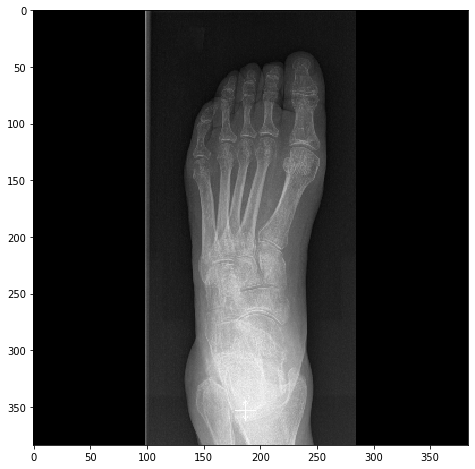

In [15]:
plt.figure(figsize=(8,8))
plt.imshow(lfs[0][1], cmap = plt.cm.gray)

In [16]:
def get_pat_id(s):
  return s.split('-')[0]

ds = []

for lf, rf, lh, rh in zip(lfs, rfs, lhs, rhs):
  if (get_pat_id(lf[0]) == get_pat_id(rf[0]) == get_pat_id(lh[0]) == get_pat_id(rh[0])):
    row1 = cv2.hconcat([lh[1], rh[1]])
    row2 = cv2.hconcat([lf[1], rf[1]])
    img = cv2.vconcat([row1, row2])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ds.append(img)
  else:
    print(lf[0], rf[0], lh[0], rh[0])

print(len(ds))

50


In [17]:
print(ds[0].shape)

(768, 768)


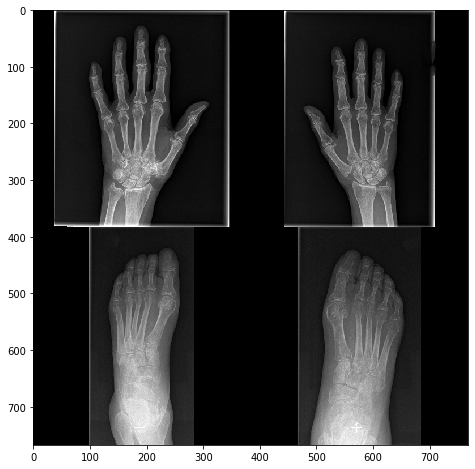

In [18]:
plt.figure(figsize=(8,8))
plt.imshow(ds[0], cmap = plt.cm.gray)

In [19]:
values = data.sort_values(by=['Patient_ID'])['Overall_Tol'].to_numpy()
values = values.astype(np.float64)
#values = values / 50 #Divide values to shift them to range 0 - 5.36 for computational stability
values

array([ 17.,  43.,  27., 128.,   8., 179.,  10.,   5.,  20., 122.,   8.,
         0.,  61.,   0.,   0.,   2.,  37., 148.,   0.,   0.,   0.,  64.,
         0.,   0.,   0.,  16.,   1.,   1.,   1.,  21.,  30.,  76.,  22.,
        50.,   0.,  20.,   9.,   0.,  87.,  34.,   0.,   0.,   0.,  11.,
         0.,  13.,  45.,  99.,  12., 262.])

In [20]:
from sklearn.model_selection import train_test_split

imgs_train, imgs_test, labels_train, labels_test = train_test_split(ds, values, test_size=0.2)

imgs_train = np.array(imgs_train)
imgs_test = np.array(imgs_test)
labels_train = np.array(labels_train)
labels_test = np.array(labels_test)

print(imgs_train.shape, imgs_test.shape, labels_train.shape, labels_test.shape)

(40, 768, 768) (10, 768, 768) (40,) (10,)


In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

reg = l2(0.05)

c_model = Sequential()

c_model.add(Conv2D(64, (3,3), activation='relu', input_shape=(side * 2,side * 2,1)))
c_model.add(Conv2D(64, (3,3), activation='relu'))
c_model.add(MaxPooling2D(pool_size=(2,2)))

c_model.add(Conv2D(128, (3,3), activation='relu'))
c_model.add(Conv2D(128, (3,3), activation='relu')) 
c_model.add(MaxPooling2D(pool_size=(2,2)))

c_model.add(Conv2D(256, (3,3), activation='relu')) 
c_model.add(Conv2D(256, (3,3), activation='relu')) 
c_model.add(Conv2D(256, (3,3), activation='relu')) 
c_model.add(MaxPooling2D(pool_size=(2,2)))

c_model.add(Conv2D(512, (3,3), activation='relu')) 
c_model.add(Conv2D(512, (3,3), activation='relu')) 
c_model.add(MaxPooling2D(pool_size=(2,2)))

c_model.add(Conv2D(1024, (3,3), activation='relu')) 
c_model.add(Conv2D(1024, (3,3), activation='relu')) 
c_model.add(MaxPooling2D(pool_size=(2,2)))

c_model.add(Conv2D(2048, (3,3), activation='relu'))
c_model.add(MaxPooling2D(pool_size=(2,2)))

c_model.add(Flatten())
c_model.add(BatchNormalization())

c_model.add(Dense(1024, activation='relu', activity_regularizer=reg))
c_model.add(BatchNormalization())
c_model.add(Dense(1024, activation='relu', activity_regularizer=reg))
c_model.add(BatchNormalization())
c_model.add(Dense(1, activation='linear'))

# Compile model
c_model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False), metrics = ['mean_absolute_error'])

In [22]:
of_train, of_label = imgs_train[:], labels_train[:]
of_val, of_val_label = imgs_test[:], labels_test[:]

of_train = of_train / 255
of_val = of_val / 255

of_train = of_train - np.mean(of_train)
of_val = of_val - np.mean(of_val)
of_train[0]

array([[-0.17269655, -0.17269655, -0.17269655, ..., -0.17269655,
        -0.17269655, -0.17269655],
       [-0.17269655, -0.17269655, -0.17269655, ..., -0.17269655,
        -0.17269655, -0.17269655],
       [-0.17269655, -0.17269655, -0.17269655, ..., -0.17269655,
        -0.17269655, -0.17269655],
       ...,
       [-0.17269655, -0.17269655, -0.17269655, ..., -0.17269655,
        -0.17269655, -0.17269655],
       [-0.17269655, -0.17269655, -0.17269655, ..., -0.17269655,
        -0.17269655, -0.17269655],
       [-0.17269655, -0.17269655, -0.17269655, ..., -0.17269655,
        -0.17269655, -0.17269655]])

In [23]:
of_train = of_train.reshape(-1, side * 2, side * 2, 1)
of_val = of_val.reshape(-1, side * 2, side * 2, 1)
of_train.shape

(40, 768, 768, 1)

In [24]:
# updatable plot
# a minimal example (sort of)

import keras
from IPython.display import clear_output

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

Using TensorFlow backend.


In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

val_datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

train_datagen.fit(of_train)
val_datagen.fit(of_val)

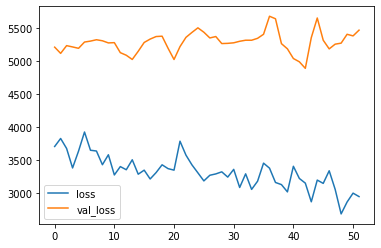

2/2 [==============================] - 77s 38s/step - loss: 2683.2523 - mean_absolute_error: 33.7979 - val_loss: 5465.9282 - val_mean_absolute_error: 45.0131
Epoch 53/100


KeyboardInterrupt: ignored

In [32]:
batch_size = 32
epochs = 100

c_model.fit_generator(train_datagen.flow(of_train, of_label, batch_size=batch_size), epochs=epochs, validation_data=val_datagen.flow(of_val, of_val_label), callbacks=[plot_losses])